# Autocorrelation structure of tree mortality

### Load data

In [13]:
import xarray as xr
import numpy as np
import os
import xrspatial
from matplotlib.colors import ListedColormap

In [2]:
mort = xr.open_dataset("../../mort_datasets/westmort.nc")["mortality"]

In [3]:
# Work on log scale
eps = 1
mort_log = np.log10(mort + eps)

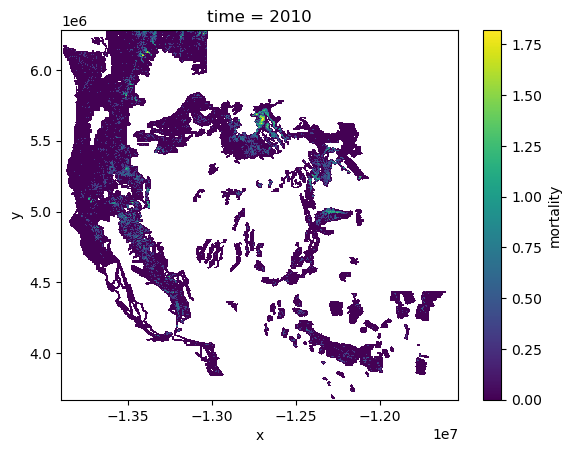

In [24]:
mort_log.sel(time=2010).plot()

In [4]:
Z_score = (mort_log - mort_log.mean()) / mort_log.std()

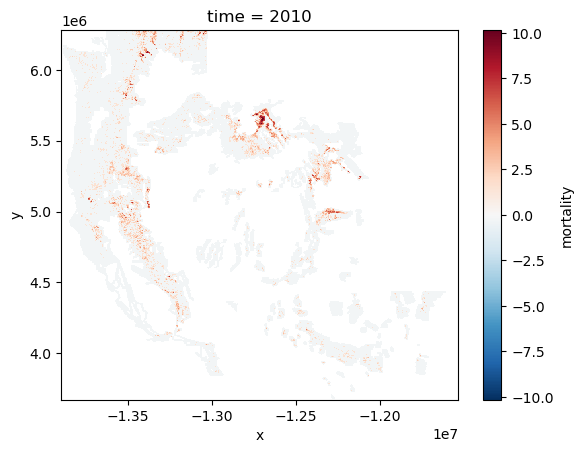

In [26]:
Z_score.sel(time=2010).plot()

The formula for the test statistic is $I_i = z_i \Sigma_j w_{ij}z_{ij}$.

In [5]:
kernel = np.array([
    [1, 1, 1],
    [1, 0, 1], # dont include central pixel
    [1, 1, 1]
])

def apply_focal(arr, kernel, func):
    arr = xr.DataArray(arr)
    return xrspatial.focal.apply(
        arr,
        kernel,
        func
    )

# Apply convolution over every slice in time
local_I = xr.apply_ufunc(
    apply_focal,
    Z_score,
    kwargs=dict(kernel=kernel, func=xrspatial.focal._calc_sum),
    vectorize=True,
    input_core_dims=[["y", "x"]],
    output_core_dims=[["y", "x"]]
)

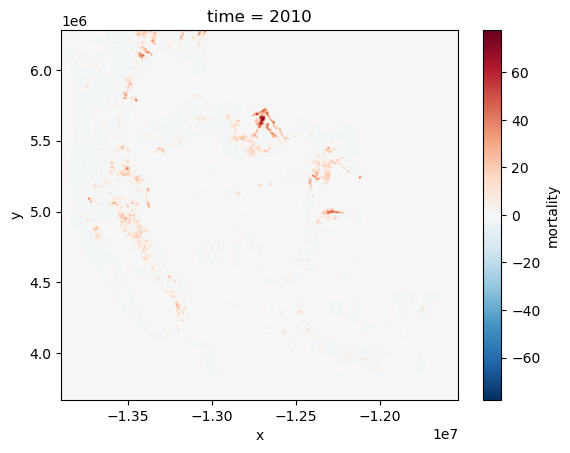

In [27]:
local_I.sel(time=2010).plot()

Now we calculate the null distribution of $I$ by permuting the array of Z scores.

In [6]:
Z_flat = Z_score.values.flatten()
Z_dist = Z_flat[~np.isnan(Z_flat)]

In [7]:
n_cells = np.prod(mort.shape)

Z_null = xr.DataArray(
    data=np.random.choice(Z_dist, size=n_cells).reshape(mort.shape),
    dims=mort.dims
)

In [8]:
I_null = xr.apply_ufunc(
    apply_focal,
    Z_null,
    kwargs=dict(kernel=kernel, func=xrspatial.focal._calc_sum),
    vectorize=True,
    input_core_dims=[["y", "x"]],
    output_core_dims=[["y", "x"]]
)

In [9]:
sig_localI = np.percentile(np.abs(I_null.values.flatten()), 99)

In [10]:
sig_map = (np.abs(local_I) > sig_localI) * np.sign(local_I)
sig_map

<xarray.DataArray 'mortality' (time: 25, y: 652, x: 590)> Size: 38MB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * x        (x) float64 5kB -1.389e+07 -1.389e+07 ... -1.154e+07 -1.154e+07
  * y        (y) float64 5kB 6.278e+06 6.274e+06 ... 3.678e+06 3.674e+06
  * time     (time) int64 200B 1999 2000 2001 2002 2003 ... 2020 2021 2022 2023

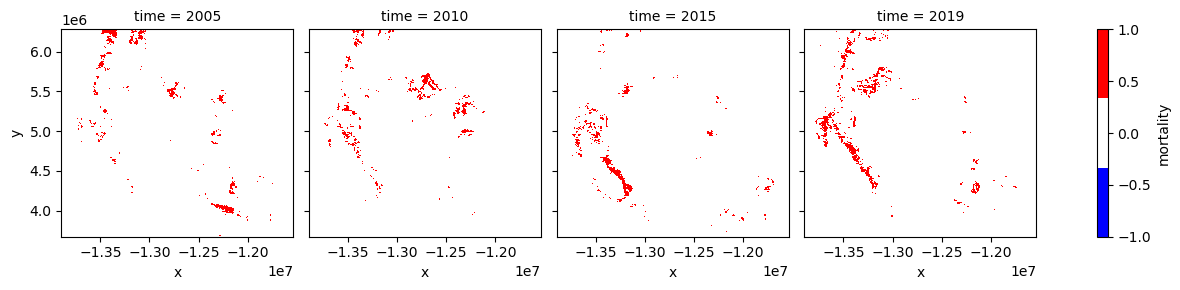

In [23]:
cmap = ListedColormap(["blue", "white", "red"])

sig_map.sel(time=[2005, 2010, 2015, 2019]).plot(col="time", cmap=cmap, vmin=-1, vmax=1)